In [9]:
# main.py
from main import gps_data_utils

import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import folium
from joblib import Parallel, delayed

import networkx as nx
import osmnx as ox
from osmnx import distance, utils_graph, settings, graph
settings.use_cache = True
settings.cache_only_mode = True

### Set Depot Points, Boundary and Buffer here

In [10]:
p1 = Point(-99.12768416729142, 19.421231015290946)
p2 = Point(-99.12729008610742, 19.420298241433308)
p3 = Point(-99.12747041774, 19.419116629726144)
p4 = Point(-99.12969297748691, 19.41926477082061)
p5 = Point(-99.12944573801215, 19.42117868427646)

points = [p1,p2,p3,p4,p5,p1]
depot = gps_data_utils.set_depot_boundary(points,buffer = 0)

### Read and Validate GPS Data here

In [11]:
'''
error_factor here is used as 1.5, i.e., 
    relative_error = abs(velocity_gps-velocity_vehicle) / velocity_vehicle 
    =>  ( 5 - 1 ) / 1 > 1.5
    => Calculated GPS speed is way higher than observed speed of the vehicle, i.e. gps walking
    => higher error_factor will allow more GPS walking
'''
error_factor = 1.25

In [12]:
cols = ['UnityLicensePlate', 'RowReferenceTime', 'lat', 'lon','Speed','EngineStatus']
date_col = ['RowReferenceTime']
d_format = 'ISO8601'
file = 'D:/Extra-Projects/MGL-India/Moving Dots/trip_data_10Units_1Year_V2.csv'

df = gps_data_utils.read_data(file,cols,date_col,d_format)
df = gps_data_utils.validate_mandatory_cols(df,'RowReferenceTime','lat','lon','Speed','UnityLicensePlate')
df = gps_data_utils.add_date_time_month_df(df)
df = df.groupby(by=['vehicleid','date']).apply(gps_data_utils.add_prev_latlong).reset_index(drop=True)
df = gps_data_utils.check_veh_within_depot(df,depot)

df['dist_prev_point'] = Parallel(n_jobs=-1, prefer="threads")(delayed(gps_data_utils.dist_calc_haversine_km)(row) for _, row in df.iterrows())

df['timediff'] = df.groupby(by=['vehicleid','date'])['timestamp'].diff().dt.total_seconds()/3600

df['velocity_gps'] = (df['dist_prev_point']/df['timediff']).fillna(0)
df['velocity_vehicle'] = (df['speed'] + df['speed'].shift(1)) / 2
df['speed_flag'] = df.apply(lambda row: ((row['velocity_vehicle'] != 0) and (abs((row['velocity_gps'] - row['velocity_vehicle']) / row['velocity_vehicle']) < error_factor)), axis=1)

In [13]:
'''
Speed is now filtered to ease the GPS walking.
'''
df = df.loc[df['speed_flag']]

df= df.reset_index(drop=True)

In [ ]:
# pd.DataFrame(df).to_csv('DF-speed-flagged.csv',index=False)

In [ ]:
# df = pd.read_csv('DF-speed-flagged.csv',parse_dates=['timestamp','time'],date_format='ISO8601')
# df = df.drop(['Unnamed: 0'],axis=1)

In [14]:
def get_network(df):
    min_lat = df['lat'].min()
    max_lat = df['lat'].max()
    min_lon = df['lon'].min()
    max_lon = df['lon'].max()

    bounding_box = (min_lat, min_lon, max_lat, max_lon)
    # create and returh the graph network
    return graph.graph_from_bbox(bounding_box[0], bounding_box[2], bounding_box[1], bounding_box[3], network_type='drive', simplify=True)

In [15]:
origin = (19.42041667,-99.12819444)  
destination = (19.33610408935329, -99.07750246715862)
# destination = (19.421231015290946,-99.12768416729142)  
G = get_network(df)

CacheOnlyInterruptError: Interrupted because `settings.cache_only_mode=True`

In [ ]:
origin_node = distance.nearest_nodes(G, origin[1], origin[0])
destination_node = distance.nearest_nodes(G, destination[1], destination[0])
# Get route from network
route = nx.shortest_path(G, source=origin_node, target=destination_node, weight='length',method='dijkstra')

In [ ]:
flmc_route_length = round(sum(utils_graph.route_to_gdf(G, route, 'length')['length'].values),2)

print("Optimal distance:", flmc_route_length, "meters")

Optimal distance: 580.63 meters


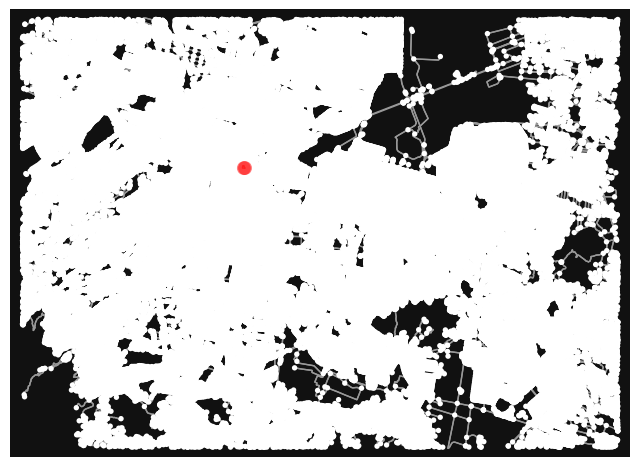

(19.23118, 19.52254)

In [31]:
fig, ax = ox.plot_graph_route(G,route,route_color='red',route_linewidth=1)
ax.set_xlim([bounding_box[1], bounding_box[3]])
ax.set_ylim([bounding_box[0], bounding_box[2]])

In [ ]:
minlen_df = 10

maps = folium.Map()
mg = folium.FeatureGroup().add_to(maps)

# single_vehicle = None
single_vehicle = 'VIG21425'

if single_vehicle:
    tempdf = df[df['vehicleid'] == single_vehicle]

    # Save the interpolated data for each combination of 'vehicleid' and 'date'
    for name, group in tempdf.groupby(['vehicleid', 'date']):
        vehicleid,date = name
        
        if len(group) > minlen_df:
            group['timestamp'] = pd.to_datetime(group['timestamp'])
            group = group.set_index('timestamp')
            group = group.resample('1S').bfill().interpolate(method = 'linear')

            geometry = [Point(xy) for xy in zip(group['lon'].notna(),group['lat'].notna())]
            groupdf = gps_data_utils.df_to_gdf(group)
            
            
            file_name = f'vehicle_{vehicleid}_date_{date}_interpolated_data.csv'
            # group.to_csv(file_name, index=False)
            folium.PolyLine(list(zip(group['lat'],group['lon'])),color=gps_data_utils.rgb_to_hex(),weight=2).add_to(mg)

In [ ]:
# groupdf = group
groupdf = gps_data_utils.df_to_gdf(group,group['lat'],group['lon'])

In [ ]:
maps.fit_bounds(mg.get_bounds())
maps